In [2]:
# %pip install scikit-learn

  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/74/17/01347a4e2298edd6d152b79d4d042f902a618ccaf4c070f0a61999a26156/scikit_learn-1.3.1-cp310-cp310-macosx_10_9_x86_64.whl.metadata
  Obtaining dependency information for scipy>=1.5.0 from https://files.pythonhosted.org/packages/65/da/4d0dfd29379c8ee3ba54b19249f673cc98448e0fd86170339fb02031f0e9/scipy-1.11.2-cp310-cp310-macosx_10_9_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 kB 5.1 MB/s eta 0:00:00
  Obtaining dependency information for joblib>=1.1.1 from https://files.pythonhosted.org/packages/10/40/d551139c85db202f1f384ba8bcf96aca2f329440a844f924c8a0040b6d02/joblib-1.3.2-py3-none-any.whl.metadata
  Obtaining dependency information for threadpoolctl>=2.0.0 from https://files.pythonhosted.org/packages/81/12/fd4dea011af9d69e1cad05c75f3f7202cdcbeac9b712eea58ca779a72865/threadpoolctl-3.2.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/1

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mutual_info_score


In [5]:
# Load the dSprites dataset
dsprites_data = np.load('dsprites-dataset/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz', encoding='bytes')
imgs = dsprites_data['imgs']
latents_values = dsprites_data['latents_values']
latents_classes = dsprites_data['latents_classes']

# Prepare the data for training
x_train = torch.tensor(imgs, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
y_train = torch.tensor(latents_classes, dtype=torch.float32)  # Ground truth factors

train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [11]:
class BetaVAEdSprites(nn.Module):
    def __init__(self, latent_dim):
        super(BetaVAEdSprites, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(64 * 64, 400),
            nn.ReLU(),
            nn.Linear(400, latent_dim * 2)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 400),
            nn.ReLU(),
            nn.Linear(400, 64 * 64),
            nn.Sigmoid()
        )
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def forward(self, x):
        h = self.encoder(x.view(-1, 64*64))
        # h = self.encoder(x.view(-1, 28 * 28))
        mu, logvar = h.chunk(2, dim=1)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar


In [9]:
# Define the Beta-VAE loss function
def beta_vae_loss(reconstructed_x, x, mu, logvar, beta=5.0):
    BCE = nn.functional.binary_cross_entropy(reconstructed_x, x.view(-1, 64*64), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta*KLD

In [7]:
import torch
from sklearn.metrics import mutual_info_score

def compute_mig(latent_vars, ground_truth_factors):
    # latent_vars: tensor of shape [num_samples, num_latent_dims]
    # ground_truth_factors: tensor of shape [num_samples, num_factors]
    
    num_latent_dims = latent_vars.size(1)
    num_factors = ground_truth_factors.size(1)
    
    mig_scores = []
    for factor_idx in range(num_factors):
        mi_scores = []
        for latent_idx in range(num_latent_dims):
            mi = mutual_info_score(latent_vars[:, latent_idx].cpu().numpy(), ground_truth_factors[:, factor_idx].cpu().numpy())
            mi_scores.append(mi)
        mi_scores.sort(reverse=True)
        mig = mi_scores[0] - mi_scores[1]  # Difference between highest and second highest MI
        mig_scores.append(mig)
    
    return torch.tensor(mig_scores).mean()  # Average MIG across all factors


In [8]:
import torch.nn.functional as F
from sklearn.linear_model import LogisticRegression

def compute_beta_vae_score(latent_vars, ground_truth_factors):
    # latent_vars: tensor of shape [num_samples, num_latent_dims]
    # ground_truth_factors: tensor of shape [num_samples, num_factors]
    
    num_latent_dims = latent_vars.size(1)
    num_factors = ground_truth_factors.size(1)
    
    beta_vae_scores = []
    for factor_idx in range(num_factors):
        scores = []
        for latent_idx in range(num_latent_dims):
            # Train a classifier to predict the ground truth factor from the latent dimension
            clf = LogisticRegression().fit(latent_vars[:, latent_idx].cpu().numpy().reshape(-1, 1), ground_truth_factors[:, factor_idx].cpu().numpy())
            score = clf.score(latent_vars[:, latent_idx].cpu().numpy().reshape(-1, 1), ground_truth_factors[:, factor_idx].cpu().numpy())
            scores.append(score)
        beta_vae_scores.append(max(scores))  # Take the highest score across all latent dimensions
    
    return torch.tensor(beta_vae_scores).mean()  # Average Beta-VAE score across all factors


In [12]:
# Initialize the model, optimizer, and device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BetaVAEdSprites(latent_dim=10).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 15
for epoch in range(epochs):
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        reconstructed_data, mu, logvar = model(data)
        loss = beta_vae_loss(reconstructed_data, data, mu, logvar)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f"Epoch {epoch} | Batch {batch_idx} | Loss: {loss.item()}")

Epoch 0 | Batch 0 | Loss: 367199.1875
Epoch 0 | Batch 100 | Loss: 38250.6953125
Epoch 0 | Batch 200 | Loss: 30448.94140625
Epoch 0 | Batch 300 | Loss: 27014.640625
Epoch 0 | Batch 400 | Loss: 25646.552734375
Epoch 0 | Batch 500 | Loss: 24001.46484375
Epoch 0 | Batch 600 | Loss: 23712.44921875
Epoch 0 | Batch 700 | Loss: 23755.453125
Epoch 0 | Batch 800 | Loss: 21796.40234375
Epoch 0 | Batch 900 | Loss: 21593.376953125
Epoch 0 | Batch 1000 | Loss: 22230.3515625
Epoch 0 | Batch 1100 | Loss: 21290.01953125
Epoch 0 | Batch 1200 | Loss: 20971.822265625
Epoch 0 | Batch 1300 | Loss: 21627.7890625
Epoch 0 | Batch 1400 | Loss: 21506.68359375
Epoch 0 | Batch 1500 | Loss: 21419.6640625
Epoch 0 | Batch 1600 | Loss: 20237.546875
Epoch 0 | Batch 1700 | Loss: 20566.841796875
Epoch 0 | Batch 1800 | Loss: 20795.8984375
Epoch 0 | Batch 1900 | Loss: 20570.0859375
Epoch 0 | Batch 2000 | Loss: 20675.5
Epoch 0 | Batch 2100 | Loss: 21549.505859375
Epoch 0 | Batch 2200 | Loss: 21008.841796875
Epoch 0 | Batch 

In [14]:
# Extract latent representations and ground truth factors
latent_vars = []
ground_truth_factors = []
for batch_idx, (data, factors) in enumerate(train_loader):
    data = data.to(device)
    reconstructed_data, mu, logvar = model(data)
    z = model.reparameterize(mu, logvar)
    latent_vars.append(z.cpu().detach())
    ground_truth_factors.append(factors.cpu().detach())
latent_vars = torch.cat(latent_vars)
ground_truth_factors = torch.cat(ground_truth_factors)

# Compute Beta-VAE score and MIG
# beta_vae_score = compute_beta_vae_score(latent_vars, ground_truth_factors)
mig = compute_mig(latent_vars, ground_truth_factors)

# print(f'Beta-VAE Score: {beta_vae_score.item()}')
print(f'MIG: {mig.item()}')

/Users/zannlim/Desktop/Y4S1/FYP 2024/.venv/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/zannlim/Desktop/Y4S1/FYP 2024/.venv/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/zannlim/Desktop/Y4S1/FYP 2024/.venv/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/Users/zannlim/Desktop/Y4S1/FYP 2024/.venv/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values b

MIG: 0.0002288567178964085


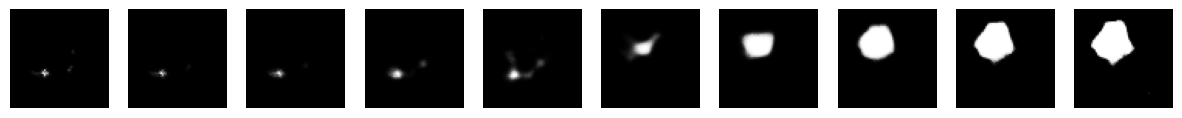

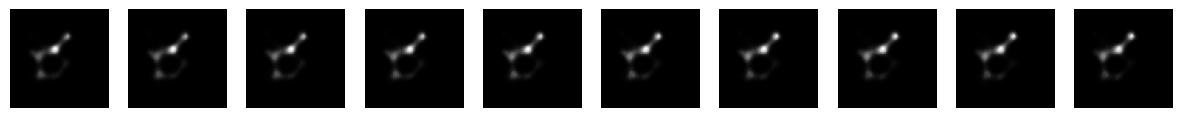

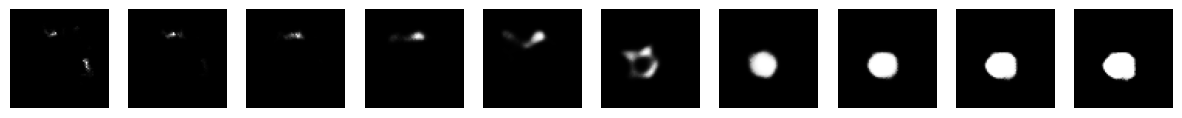

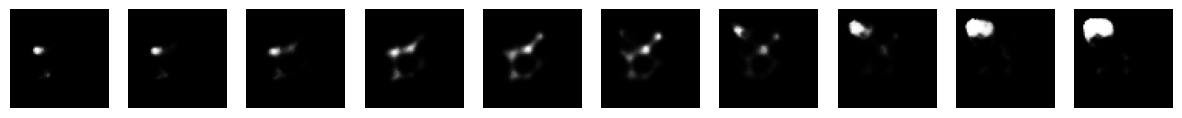

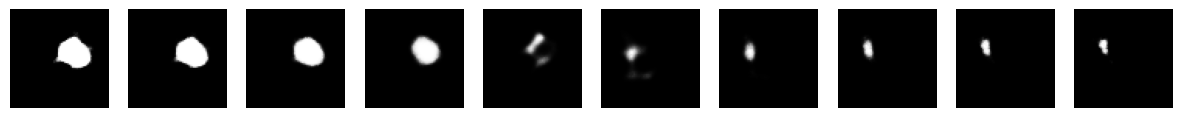

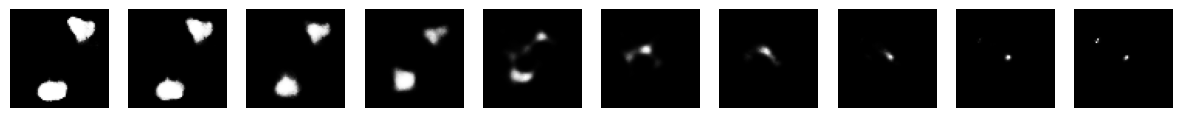

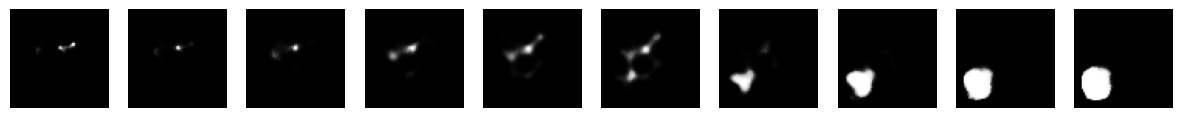

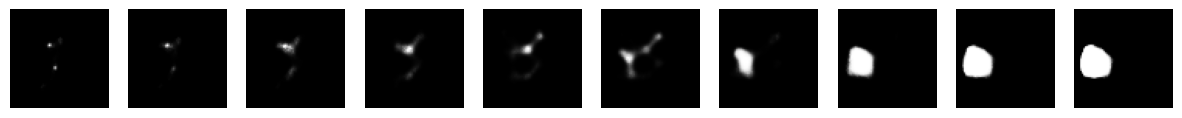

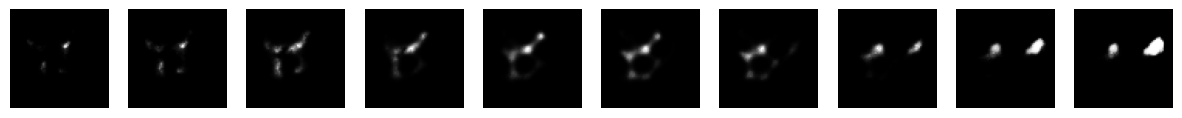

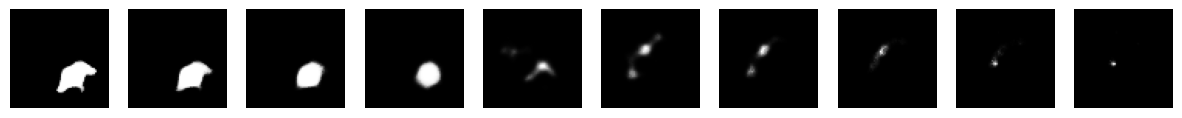

In [15]:
def traverse_latents(model, latent_dim, num_points=10):
    for dim in range(latent_dim):
        # Create a batch of latent vectors, with all dimensions fixed except for dim
        z = torch.zeros(num_points, latent_dim)
        z[:, dim] = torch.linspace(-6, 6, num_points)  # Vary dim from -3 to 3
        z = z.to(device)
        
        # Decode the latent vectors into images
        generated_images = model.decoder(z)
        
        # Reshape and plot the generated images
        generated_images = generated_images.cpu().detach().numpy().reshape(-1, 64, 64)
        fig, axs = plt.subplots(1, num_points, figsize=(15, 2))
        for i, ax in enumerate(axs):
            ax.imshow(generated_images[i], cmap='gray')
            ax.axis('off')
        plt.show()

# Call the function to visualize the effect of changing each dimension in the latent space
traverse_latents(model, latent_dim=10)